In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from helpers.pandas import standardize

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(0)

In [3]:
data = pd.read_csv("./data/WaffleDivorce.csv", delimiter=";")
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


### Figure 5.1


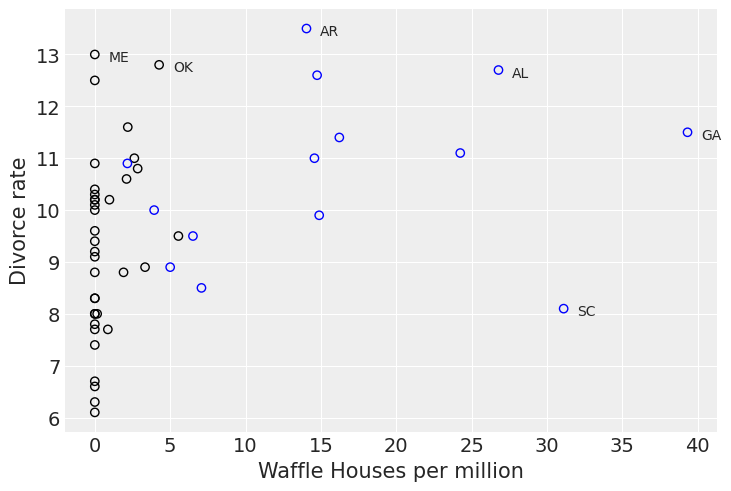

In [4]:
fig, ax = plt.subplots()

# assign colours to confederate states
colors = {"1": "blue", "0": "black"}

ax.scatter(
    data["WaffleHouses"] / data["Population"],
    data["Divorce"],
    lw=1,
    color=(0, 0, 0, 0),
    edgecolor=data["South"].apply(lambda x: colors[str(x)]),
)

ax.set_xlabel("Waffle Houses per million")
ax.set_ylabel("Divorce rate")

# take only the states with Divorce rate over 12.6 or number of Waffle houses per million inhabitants over 30
selection = data[
    (data["Divorce"] > 12.6) | (data["WaffleHouses"] / data["Population"] > 30)
]

# label those points
for state, div, ratio in zip(
    selection["Loc"],
    selection["WaffleHouses"] / selection["Population"],
    selection["Divorce"],
):
    ax.annotate(
        f"{state}", xy=(div, ratio), textcoords="offset points", xytext=(10, -5)
    )

### Code 5.1


In [5]:
# Standardize regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

In [6]:
with pm.Model() as m5_3:
    A = data["MedianAgeMarriage"]
    M = data["Marriage"]
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    bA = pm.Normal("bA", mu=0, sigma=0.5)
    bM = pm.Normal("bM", mu=0, sigma=0.5)
    mu = alpha + bM * M + bA * A
    sigma = pm.Exponential("sigma", 1)
    pm.Normal("M", mu=mu, sigma=sigma)

    map_estimate = pm.find_MAP()
    trace = pm.sample(draws=2000, tune=1000)

Output()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bA, bM, sigma, M]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.
There were 958 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.010,0.197,-0.390,0.340,0.009,0.006,480.0,850.0,1.01
bA,-0.019,0.497,-0.965,0.820,0.105,0.075,24.0,173.0,1.13
bM,-0.083,0.495,-0.925,0.857,0.064,0.046,61.0,131.0,1.04
M[0],-2.205,16.586,-26.679,27.408,3.537,2.535,26.0,50.0,1.15
M[1],-2.678,18.572,-29.756,30.246,3.789,2.712,27.0,52.0,1.14
M[2],-2.127,16.861,-27.117,27.613,3.635,2.606,25.0,46.0,1.15
M[3],-2.690,18.455,-30.684,29.207,3.723,2.664,27.0,56.0,1.13
M[4],-2.075,16.955,-27.594,27.932,3.680,2.639,25.0,39.0,1.15
M[5],-2.480,17.868,-29.538,28.242,3.759,2.693,26.0,51.0,1.14
M[6],-1.945,16.621,-28.939,25.669,3.651,2.619,24.0,45.0,1.15


### Code 5.10


In [8]:
with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu",
        a
        + bM * data["Marriage_std"].values
        + bA * data["MedianAgeMarriage_std"].values,
    )

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_3_trace = pm.sample()

Sampling: [a, bA, bM, divorce_rate_std, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


## 5.1.5.1 Predictor Residual Plot

"The benefit of computing these things is that, once plotted against the outcome, we have a bivariate regression that has already conditioned on all of the other predictor variables. It leaves the variation that is not expected by the model of the mean, µ, as a function of the other predictors."


### Code 5.13


In [9]:
data.columns

Index(['Location', 'Loc', 'Population', 'MedianAgeMarriage', 'Marriage',
       'Marriage SE', 'Divorce', 'Divorce SE', 'WaffleHouses', 'South',
       'Slaves1860', 'Population1860', 'PropSlaves1860', 'Divorce_std',
       'Marriage_std', 'MedianAgeMarriage_std'],
      dtype='object')

In [10]:
with pm.Model() as m5_4:
    a = pm.Normal("a", mu=0, sigma=0.2)
    bAM = pm.Normal("bAM", mu=0, sigma=0.5)

    mu = pm.Deterministic("mu", a + bAM * data["MedianAgeMarriage_std"].values)
    sigma = pm.Exponential("sigma", 1)

    marriage_std = pm.Normal(
        "Marriage_std", mu=mu, sigma=sigma, observed=data["Marriage_std"].values
    )
    priors = pm.sample_prior_predictive()
    m5_4_trace = pm.sample()

Sampling: [Marriage_std, a, bAM, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bAM, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


### Code 5.14


"When a residual is positive, that means that the observed rate was in excess of what the model expects, given the median age at marriage in that State. When a residual is negative, that means the observed rate was below what the model expects."


In [11]:
mu_m5_4_mean = m5_4_trace.posterior["mu"].mean(dim=["chain", "draw"])
residuals = data["Marriage_std"] - mu_m5_4_mean

residuals

0    -0.397300
1     1.074089
2    -0.092124
3     0.677489
4     0.149602
5     0.694676
6     0.069148
7     1.091276
8     1.398279
9    -0.626410
10    0.437590
11    1.732529
12   -0.093952
13   -0.054824
14   -0.279545
15    0.000763
16   -0.064331
17   -0.149538
18    0.042636
19   -1.547971
20    0.217805
21    0.228775
22   -0.758062
23   -1.129794
24   -0.355427
25   -0.651277
26   -0.621839
27   -0.499512
28   -0.482325
29   -0.480680
30   -0.065794
31    0.436309
32   -0.121563
33    1.314170
34   -0.708510
35    0.048670
36   -0.349211
37   -0.630982
38   -0.149174
39   -0.336777
40   -0.256323
41   -0.663711
42   -0.110775
43    0.962369
44   -0.505547
45    0.295150
46    0.253278
47   -0.038000
48   -0.629519
49    1.753923
Name: Marriage_std, dtype: float64

## 5.1.5.2 Posterior Prediction


### Code 5.15


In [12]:
# Use model m_5_3 and adjust
with m_5_3:
    m_5_3_ppc = pm.sample_posterior_predictive(
        m_5_3_trace, var_names=["mu", "divorce_rate_std"]
    )

# Summarize samples across cases
mu_mean = m_5_3_ppc.posterior_predictive["mu"].mean(dim=["chain", "draw"])
mu_PI = az.hdi(m_5_3_ppc.posterior_predictive["mu"], 0.89)

# Simulate observations
D_sim = m_5_3_ppc.posterior_predictive["divorce_rate_std"].mean(dim=["chain", "draw"])
D_PI = az.hdi(m_5_3_ppc.posterior_predictive["divorce_rate_std"], 0.89)

Sampling: [divorce_rate_std]


Output()

"This code is similar to what you’ve seen before, but now using the original observed data. For multivariate models, there are many difefrent ways to display these simulations. **The simplest is to just plot predictions against observed.**"


### Code 5.16


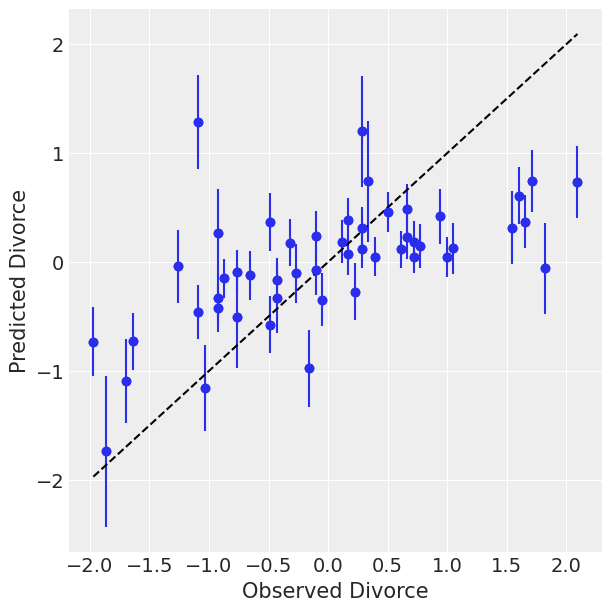

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    data["Divorce_std"].values,
    D_sim,
    yerr=np.abs(np.array(D_sim) - mu_PI.min(dim="hdi").to_array()),
    fmt="C0o",
)
ax.scatter(data["Divorce_std"].values, D_sim)

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");